In [33]:
import numpy as np
import os
import glob
import tensorflow as tf
import cv2
from tensorflow import keras

In [34]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from keras.models import Model
from keras import regularizers
from keras.layers import Conv2D, ReLU, Input
from keras.callbacks import ReduceLROnPlateau

In [ ]:
original_images_path = "Original_Images"
hazy_images_path = "Training_Images"

In [36]:
original_image_paths = glob.glob(original_images_path + "/*.jpg")
n = len(original_image_paths)
print('Original Images -', n)

train_keys, val_keys = train_test_split(original_image_paths, test_size = 0.1, random_state = 42)
print('Train Images -', len(train_keys))
print('Val Images -', len(val_keys))

print(original_image_paths[0])

Original Images - 125
Train Images - 112
Val Images - 13
/kaggle/input/nyu2-mini-125/Original_Images/NYU2_77.jpg


In [37]:
split_dict = {}

for keys in train_keys:
    split_dict[keys] = 'train'
for keys in val_keys:
    split_dict[keys] = 'val'

In [38]:
train_data = []
val_data = []

hazy_image_paths = glob.glob(hazy_images_path + "/*.jpg")
print('Hazy Images -', len(hazy_image_paths))

for path in hazy_image_paths:
    # print(path)
    label = path.split('/')[-1]

    # print(label)
    # print(label.split('_'))

    corr_original_path = original_images_path + '/' + label.split('_')[0] + '_' + label.split('_')[1] + '.jpg' # Corrsponding Original Image for Haze Image Path

#     print(corr_original_path)

    if (split_dict[corr_original_path] == 'train'):
        train_data.append([path, corr_original_path])
    else:
        val_data.append([path, corr_original_path])
        
# [Hazy Image,  Original Image]

# print(train_data[0])
# print(val_data[0])

Hazy Images - 2212


In [39]:
def image_read(path):
    img_arr = cv2.imread(path)
    return cv2.resize(img_arr, (325, 240), interpolation = cv2.INTER_LINEAR)

In [40]:
train_x = []
train_y = []
val_x = []
val_y = []

print('Train Length ', len(train_data))
print('Val Length ', len(val_data))

for i in range(len(train_data)):
#     print('train ', i + 1)
    train_x.append(image_read(train_data[i][0]))
    train_y.append(image_read(train_data[i][1]))

for i in range(len(val_data)):
#     print('val ', i + 1)
    val_x.append(image_read(val_data[i][0]))
    val_y.append(image_read(val_data[i][1]))

Train Length  1991
Val Length  221


Text(0.5, 1.0, 'Val Hazy Image')

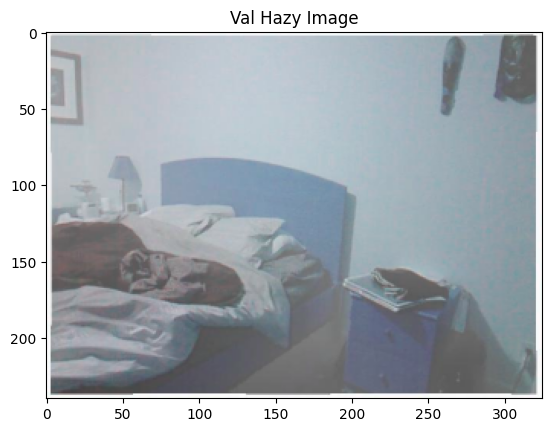

In [41]:
plt.imshow(val_x[30])
plt.title('Val Hazy Image')

Text(0.5, 1.0, 'Val Original Image')

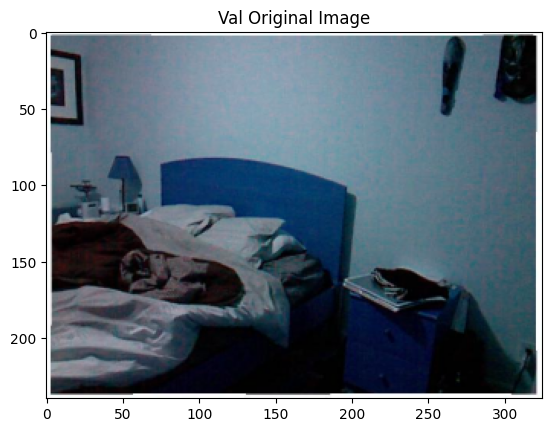

In [42]:
plt.imshow(val_y[30])
plt.title('Val Original Image')

Text(0.5, 1.0, 'Hazy Image')

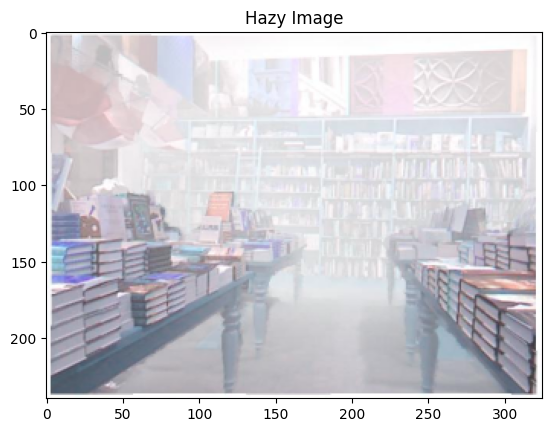

In [43]:
plt.imshow(train_x[12])
plt.title('Hazy Image')

Text(0.5, 1.0, 'Original Image')

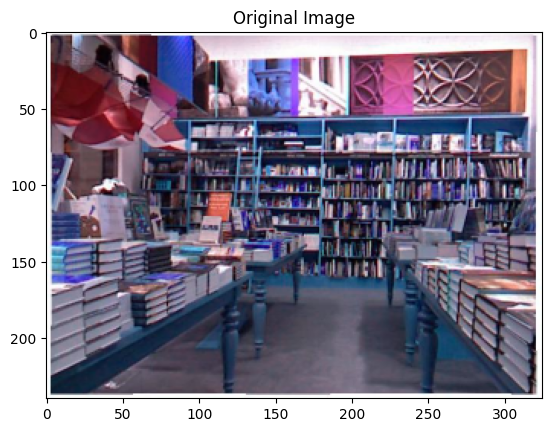

In [44]:
plt.imshow(train_y[12])
plt.title('Original Image')

In [45]:
train_x = np.array(train_x) / 255
train_y = np.array(train_y) / 255
val_x = np.array(val_x) / 255
val_y = np.array(val_y) / 255

# train_x = train_x.reshape(-1, 650, 480, 3)
# train_y = train_y.reshape(-1, 650, 480, 3)
# val_x = val_x.reshape(-1, 650, 480, 3)
# val_y = val_y.reshape(-1, 650, 480, 3)

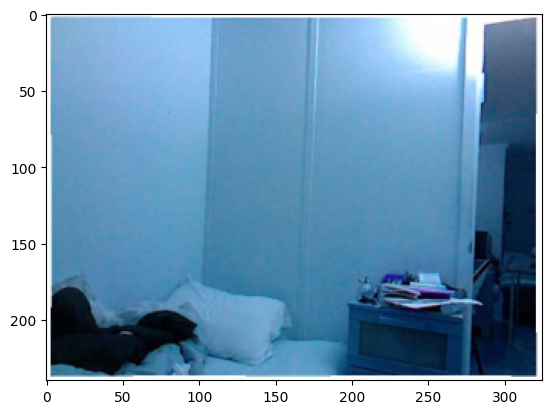

In [46]:
plt.imshow(train_y[1])

In [47]:
input = Input(shape = (240, 325, 3))
conv1 = Conv2D(3, 1, 1, padding = 'same', activation = 'relu', use_bias = True, kernel_initializer = 'RandomNormal', kernel_regularizer = regularizers.L2(l2 = 0.01))(input)
conv2 = Conv2D(3, 1, 1, padding = 'same', activation = 'relu', use_bias = True, kernel_initializer = 'RandomNormal', kernel_regularizer = regularizers.L2(l2 = 0.01))(conv1)
concat1 = tf.concat([conv1, conv2], axis = -1)

conv3 = Conv2D(3, 5, 1, padding = 'same', activation = 'relu', use_bias = True, kernel_initializer = 'RandomNormal', kernel_regularizer = regularizers.L2(l2 = 0.01))(concat1) # stddev = 0.05
concat2 = tf.concat([conv2, conv3], axis = -1)

conv4 = Conv2D(3, 7, 1, padding = 'same', activation = 'relu', use_bias = True, kernel_initializer = 'RandomNormal', kernel_regularizer = regularizers.L2(l2 = 0.01))(concat2) # stddev = 0.05
concat3 = tf.concat([conv1, conv2, conv3, conv4], axis = -1)

conv5 = Conv2D(3, 3, 1, padding = 'same', activation = 'relu', use_bias = True, kernel_initializer = 'RandomNormal', kernel_regularizer = regularizers.L2(l2 = 0.01))(concat3) # stddev = 0.05

K = conv5

output = ReLU(max_value = 1.0)(tf.math.multiply(K, input) - K + 1.0)

model = Model(inputs = input, outputs = output)

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 325, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 240, 325, 3)          12        ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 240, 325, 3)          12        ['conv2d[0][0]']              
                                                                                                  
 tf.concat (TFOpLambda)      (None, 240, 325, 6)          0         ['conv2d[0][0]',              
                                                                     'conv2d_1[0][0]']        

In [48]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.3, min_lr=0.000001)
print(len(train_x))
print(len(train_y))

1991
1991


In [49]:
history = model.fit(x = train_x, y = train_y, batch_size = 32, epochs = 25 , validation_data = (val_x, val_y), callbacks = [learning_rate_reduction])

Epoch 1/25
63/63 [==============================] - 17s 112ms/step - loss: 0.2825 - accuracy: 0.1567 - val_loss: 0.0451 - val_accuracy: 0.2309 - lr: 0.0010
Epoch 2/25
63/63 [==============================] - 5s 78ms/step - loss: 0.0374 - accuracy: 0.7690 - val_loss: 0.0280 - val_accuracy: 0.8941 - lr: 0.0010
Epoch 3/25
63/63 [==============================] - 5s 79ms/step - loss: 0.0296 - accuracy: 0.8942 - val_loss: 0.0250 - val_accuracy: 0.8943 - lr: 0.0010
Epoch 4/25
63/63 [==============================] - 5s 79ms/step - loss: 0.0270 - accuracy: 0.8947 - val_loss: 0.0228 - val_accuracy: 0.8912 - lr: 0.0010
Epoch 5/25
63/63 [==============================] - 5s 78ms/step - loss: 0.0248 - accuracy: 0.8970 - val_loss: 0.0208 - val_accuracy: 0.9006 - lr: 0.0010
Epoch 6/25
63/63 [==============================] - 5s 78ms/step - loss: 0.0230 - accuracy: 0.9027 - val_loss: 0.0189 - val_accuracy: 0.9089 - lr: 0.0010
Epoch 7/25
63/63 [==============================] - 5s 78ms/step - loss: 0

In [ ]:
print("Loss of the model is - ", model.evaluate(val_x, val_y)[0])
print("Accuracy of the model is - ", model.evaluate(val_x, val_y)[1] * 100, '%')
model.save('Custom_Model')

7/7 [==============================] - 0s 33ms/step - loss: 0.0168 - accuracy: 0.9123
Loss of the model is -  0.016819030046463013
7/7 [==============================] - 0s 34ms/step - loss: 0.0168 - accuracy: 0.9123
Accuracy of the model is -  91.23031497001648 %


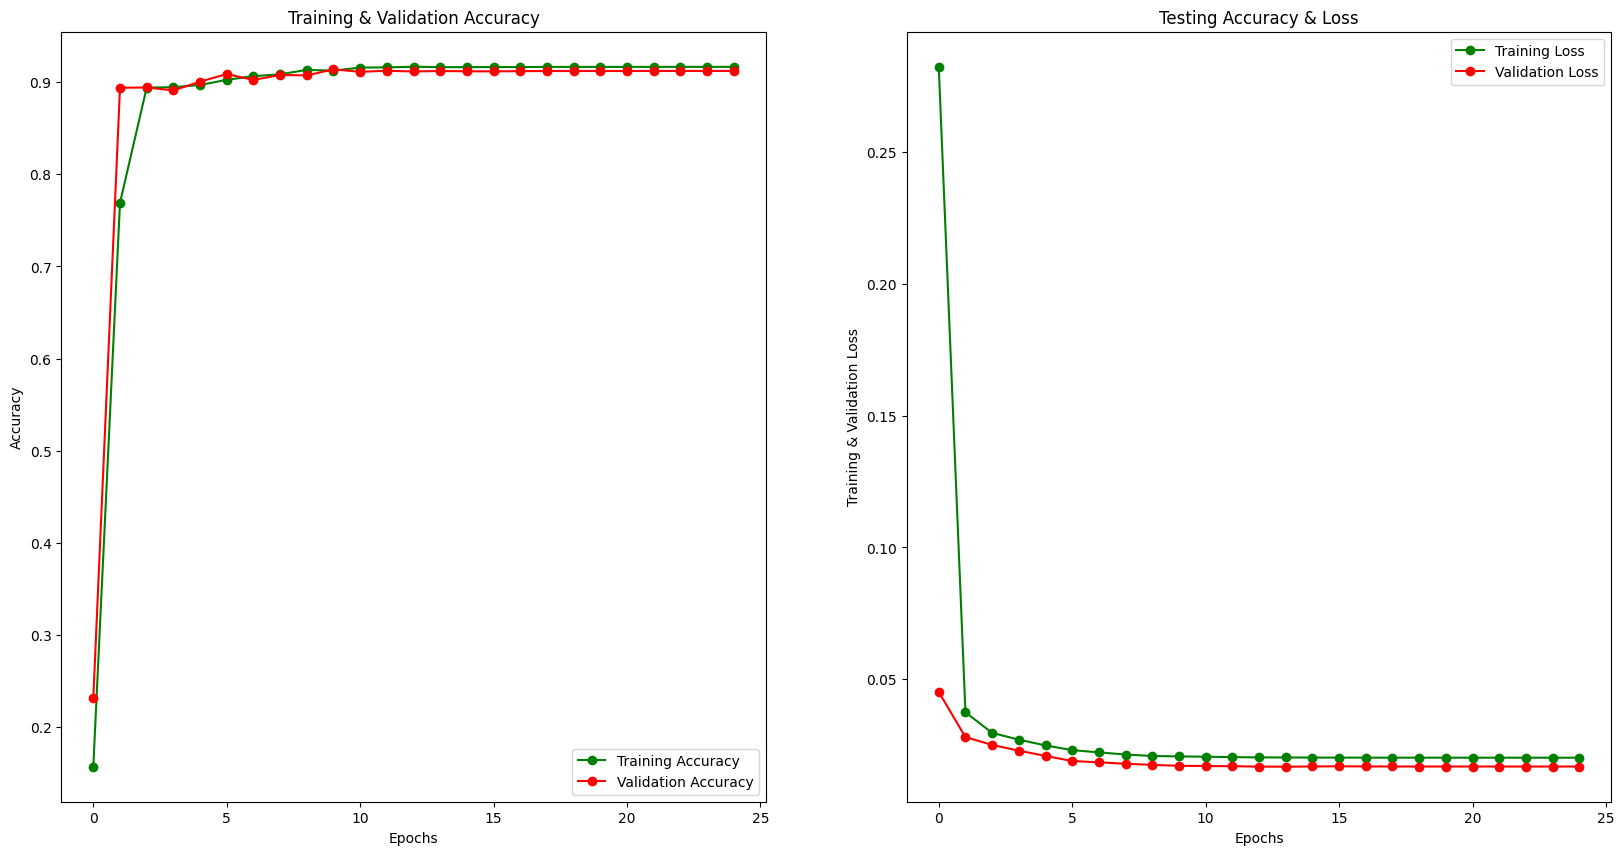

In [51]:
epochs = [i for i in range(25)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [52]:
predictions = model.predict(val_x)

7/7 [==============================] - 0s 27ms/step


In [74]:
test_original_path = '/kaggle/input/nyu2-mini-125/Testing Images/Original_Images'
test_hazy_path = '/kaggle/input/nyu2-mini-125/Testing Images/Hazy_Images'
test_ds = glob.glob(test_hazy_path + "/*.jpg")

In [75]:
test_x = []
test_y = []
for path in test_ds:
    temp_original_path = test_original_path + '/NYU2_' + path.split('/')[-1].split('_')[1] + '.jpg'
    
    test_x.append(image_read(path))
    test_y.append(image_read(temp_original_path))
    
print(len(test_x))
print(len(test_y))

6
6


In [76]:
test_x = np.array(test_x) / 255
test_y = np.array(test_y) / 255

In [77]:
predictions = model.predict(test_x)

1/1 [==============================] - 0s 24ms/step


Text(0.5, 1.0, 'Hazy Image')

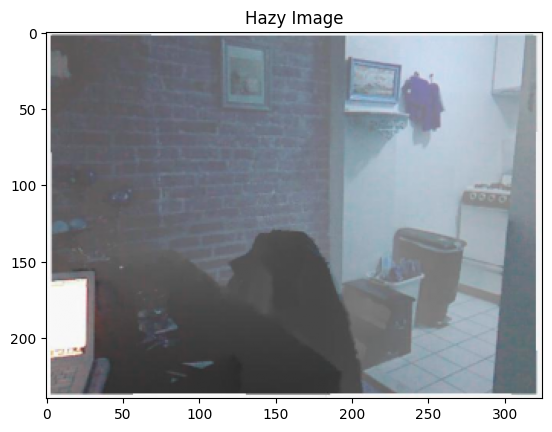

In [78]:
plt.imshow(test_x[1])
plt.title('Hazy Image')

Text(0.5, 1.0, 'Predicted Image')

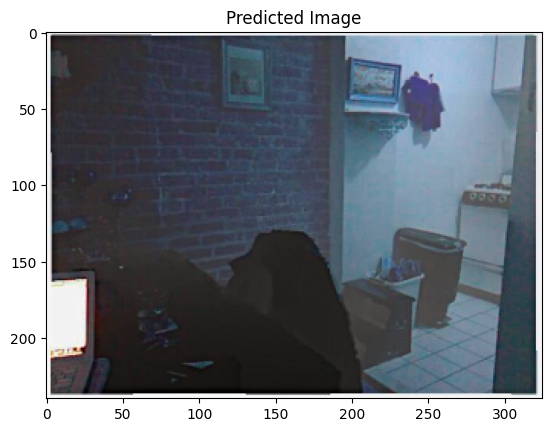

In [79]:
plt.imshow(predictions[1])
plt.title('Predicted Image')

Text(0.5, 1.0, 'Expected Output')

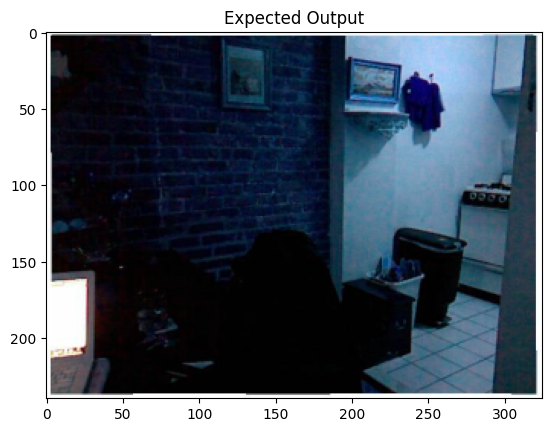

In [80]:
plt.imshow(test_y[1])
plt.title('Expected Output')